#### Analysis of stem cells niches in Xenium add-on panel healthy gut data with `NicheCompass`
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 25th March 2024

#### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import warnings
from datetime import datetime
#import gdown

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

#### Define Parameters

In [3]:
### Dataset ###
dataset = "human_intestine"
species = "human"
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "CellType2"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

#### Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

#### Configure Paths

In [6]:
!pwd

/home/amaguza


In [7]:
# Define paths
ga_data_folder_path = "/home/amaguza/NicheCompass/data/gene_annotations"
gp_data_folder_path = "/home/amaguza/NicheCompass/data/gene_programs"
so_data_folder_path = "/home/amaguza/NicheCompass/data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"/home/amaguza/NicheCompass/artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

#### Create Directories

In [8]:
import os
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

#### Upload the anndata file

In [9]:
adata = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_celltypes_and_stem_cells_types.h5ad')

#### Prepare Model Training

+ Create Prior Knowledge Gene Program (GP) Mask

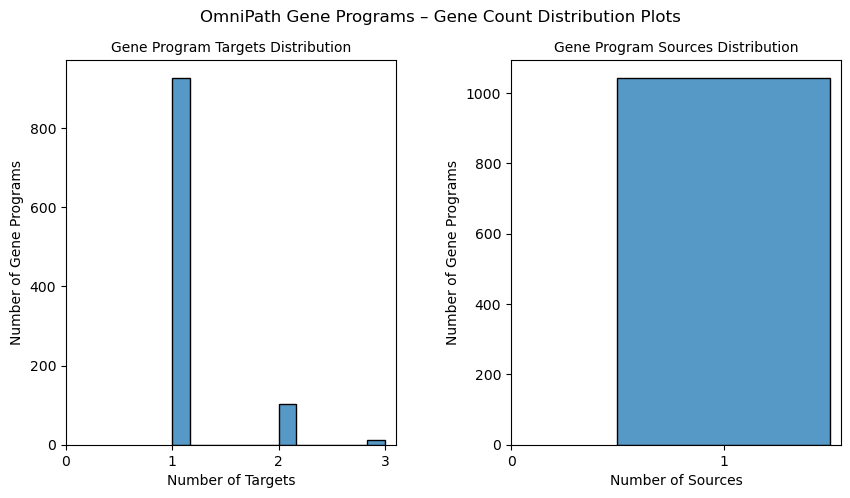

In [10]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [11]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

PRL_ligand_receptor_GP: {'sources': ['PRL'], 'targets': ['GHR'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


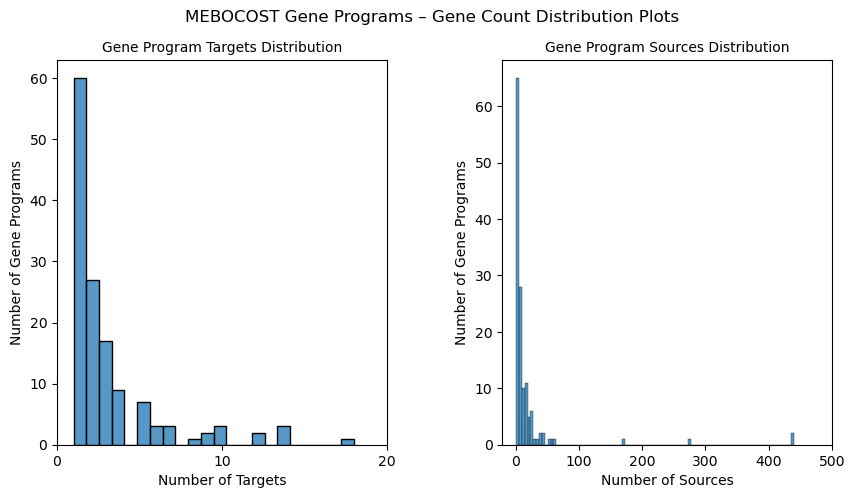

In [12]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [13]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Oxoglutaric acid_metabolite_enzyme_sensor_GP: {'sources': ['AADAT', 'AASS', 'ABAT', 'ADHFE1', 'AGXT', 'AGXT2', 'ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALKBH1', 'ALKBH2', 'ASPH', 'BBOX1', 'BCAT1', 'BCAT2', 'CCBL1', 'CCBL2', 'D2HGDH', 'DHTKD1', 'EGLN1', 'EGLN2', 'EGLN3', 'GLUD1', 'GLUD2', 'GOT1', 'GOT1L1', 'GOT2', 'GPT', 'GPT2', 'HIF1AN', 'IDH1', 'IDH2', 'IDH3A', 'IDH3B', 'IDH3G', 'KDM2A', 'KDM2B', 'KDM8', 'L2HGDH', 'LEPRE1', 'LEPREL1', 'LEPREL2', 'MINA', 'NIT2', 'NO66', 'OAT', 'OGDH', 'OGDHL', 'P4HA1', 'P4HA2', 'P4HA3', 'P4HTM', 'PHF8', 'PHGDH', 'PHYH', 'PLOD1', 'PLOD2', 'PLOD3', 'PSAT1', 'TAT', 'TET1', 'TET2', 'TET3', 'TMLHE'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme',

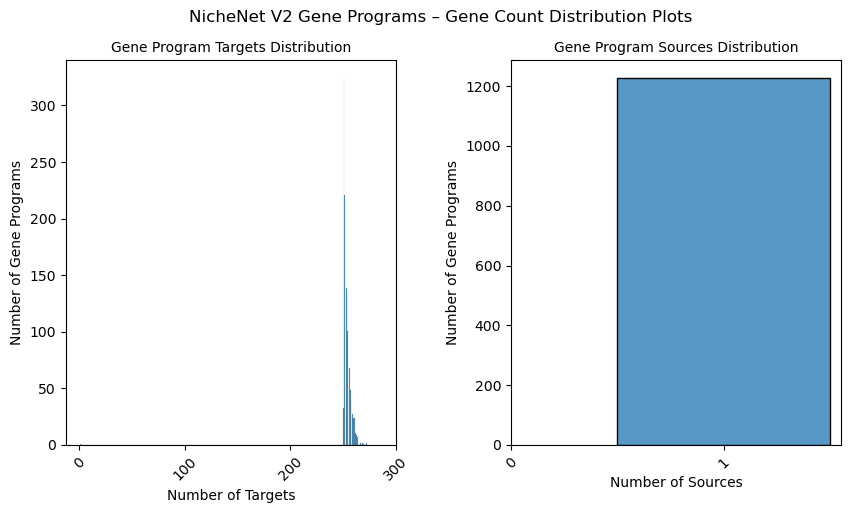

In [14]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [15]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

S100A10_ligand_receptor_target_gene_GP: {'sources': ['S100A10'], 'targets': ['TRPV5', 'TRPV6', 'CFTR', 'HTR1B', 'A2M', 'ABL1', 'ADM', 'AHNAK', 'AHR', 'ANKRD1', 'APP', 'AR', 'ARID5B', 'ASS1', 'ATF3', 'BAX', 'BCL2', 'BCL2L1', 'BCL2L11', 'BCL3', 'BCL6', 'BDNF', 'BHLHE40', 'BIRC3', 'BIRC5', 'BMP4', 'BNIP3L', 'BRCA1', 'BTG1', 'BTG2', 'CA12', 'CAV1', 'CBX4', 'CBX5', 'CCL2', 'CCL5', 'CCN1', 'CCN2', 'CCNA2', 'CCNB1', 'CCND1', 'CCND2', 'CCND3', 'CD44', 'CDH1', 'CDK1', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2C', 'CEBPA', 'CEBPB', 'CITED2', 'CORO1C', 'CRABP2', 'CRKL', 'CSF2', 'CTNNB1', 'CXCL8', 'CXCR4', 'CYP1A1', 'CYP1B1', 'DDIT3', 'DDIT4', 'DHRS3', 'DKK1', 'DMD', 'DTL', 'DUSP1', 'DUSP4', 'DUSP5', 'DUSP6', 'E2F1', 'EDN1', 'EFHD1', 'EFNA1', 'EGFR', 'EGR1', 'EGR2', 'EGR3', 'EIF4E', 'ELOVL6', 'ENO3', 'EPAS1', 'EPB41', 'EPHA2', 'ESR1', 'ETFB', 'ETV4', 'FAS', 'FASN', 'FKBP5', 'FN1', 'FOS', 'FOSL1', 'FOXA1', 'FOXO3', 'FST', 'GADD45A', 'GADD45B', 'GADD45G', 'GAPDH', 'GATA3', 'GDF15', 'GSE1', 'H2AC6', 

In [16]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [17]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2406.
Number of gene programs after filtering and combining: 1987.


#### Compute Spatial Neighbor Graph for adata

In [18]:
adata.obs

,imagecol,imagerow,Cell_Type,Stem_cells,CellType2
cell_id,,,,,
aaaagkoa-1,3320.588867,3346.253662,Mesenchymal,Unknown,Mesenchymal
aaablbol-1,2941.872070,3417.557129,Mesenchymal,Unknown,Mesenchymal
aaabogma-1,3389.693848,3386.532959,Mesenchymal,Unknown,Mesenchymal
aaabpdim-1,6174.784180,16895.193359,Mesenchymal,Unknown,Mesenchymal
aaabpfoj-1,6204.396484,16880.251953,Mesenchymal,Unknown,Mesenchymal
...,...,...,...,...,...
oikabfkp-1,33136.144531,12246.299805,Epithelial,Unknown,Epithelial
oikalpjm-1,33070.058594,12269.489258,Epithelial,Unknown,Epithelial
oikamhom-1,33041.335938,12274.116211,Epithelial,Unknown,Epithelial


In [19]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

+ Add GP Mask to Data

In [20]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

+ Explore Data

In [21]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

In [22]:
adata.layers['counts'] = adata.X.copy()

In [23]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

Number of nodes (observations): 275822
Number of node features (genes): 425


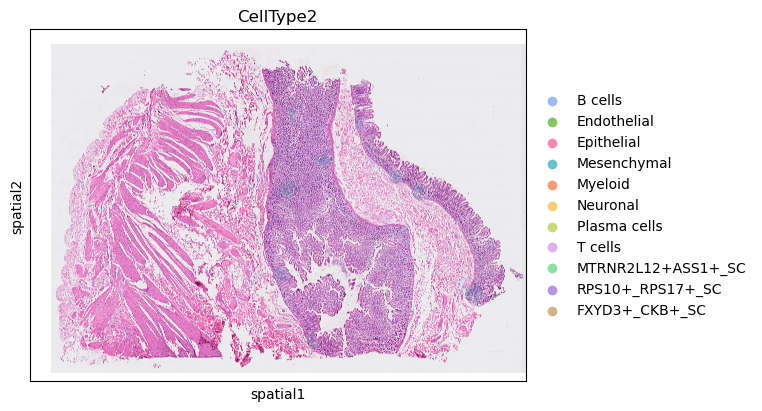

In [24]:
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)        

#### Train Model

+ Initialize, Train & Save Model

In [25]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 425, n_cat_covariates_embed_input: 0, n_hidden: 207, n_latent: 107, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 107, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 425


In [26]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 248240
Number of validation nodes: 27582
Number of training edges: 587526
Number of validation edges: 65280
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 375247.7582; train_optim_loss: 375247.7582; val_global_loss: 361309.6006; val_optim_loss: 361309.6006
Epoch 2/400 |--------------------| 0.5% train_global_loss: 354916.6329; train_optim_loss: 354916.6329; val_global_loss: 354554.2495; val_optim_loss: 354554.2495
Epoch 3/400 |--------------------| 0.8% train_global_loss: 349655.0145; train_optim_loss: 349655.0145; val_global_loss: 350887.6167; val_optim_loss: 350887.6167
Epoch 4/400 |--------------------| 1.0% train_global_loss: 346421.2993; train_optim_loss: 346421.2993; val_global_loss: 347668.3286; val_optim_loss: 347668.3286
Epoch 5/400 |--------------------| 1.2% train_global_loss: 344167.3511; train_optim_loss: 344167.3511; val_global_loss: 3460

In [27]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [28]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")